In [41]:
### I am going to spool an AWS instance as my local enviornment is broken at the moment, blame docker. I am checking to see if I am on the right instance below.
import subprocess
import psutil
values = psutil.virtual_memory()
total = values.total >> 30

cpuinfo=((subprocess.check_output("lscpu", shell=True).strip()).decode()).splitlines()

for i in cpuinfo[0:8]:
    print(i)
print('Total Ram: {} Gb'.format(str(total).rjust(25)))

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Address sizes:                   48 bits physical, 48 bits virtual
Byte Order:                      Little Endian
CPU(s):                          64
On-line CPU(s) list:             0-63
Vendor ID:                       AuthenticAMD
Model name:                      AMD EPYC 7R13 Processor
Total Ram:                       123 Gb


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("ames_housing_data.csv")
df['TotalFloorSF'] = df['FirstFlrSF'] + df['SecondFlrSF']
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
df['QualityIndex'] = df['OverallQual'] * df['OverallCond']
df['logSalePrice'] = np.log(df['SalePrice'])
df['price_sqft'] = df['SalePrice'] / df['TotalFloorSF']
print(df.shape)
print(df.info())
print(df.head())
print(df.columns)
print(df['price_sqft'].describe())

(2930, 87)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 87 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SID            2930 non-null   int64  
 1   PID            2930 non-null   int64  
 2   SubClass       2930 non-null   int64  
 3   Zoning         2930 non-null   object 
 4   LotFrontage    2440 non-null   float64
 5   LotArea        2930 non-null   int64  
 6   Street         2930 non-null   object 
 7   Alley          198 non-null    object 
 8   LotShape       2930 non-null   object 
 9   LandContour    2930 non-null   object 
 10  Utilities      2930 non-null   object 
 11  LotConfig      2930 non-null   object 
 12  LandSlope      2930 non-null   object 
 13  Neighborhood   2930 non-null   object 
 14  Condition1     2930 non-null   object 
 15  Condition2     2930 non-null   object 
 16  BldgType       2930 non-null   object 
 17  HouseStyle     2930 non-null   object 
 1

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 87 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SID            2930 non-null   int64  
 1   PID            2930 non-null   int64  
 2   SubClass       2930 non-null   int64  
 3   Zoning         2930 non-null   object 
 4   LotFrontage    2440 non-null   float64
 5   LotArea        2930 non-null   int64  
 6   Street         2930 non-null   object 
 7   Alley          198 non-null    object 
 8   LotShape       2930 non-null   object 
 9   LandContour    2930 non-null   object 
 10  Utilities      2930 non-null   object 
 11  LotConfig      2930 non-null   object 
 12  LandSlope      2930 non-null   object 
 13  Neighborhood   2930 non-null   object 
 14  Condition1     2930 non-null   object 
 15  Condition2     2930 non-null   object 
 16  BldgType       2930 non-null   object 
 17  HouseStyle     2930 non-null   object 
 18  OverallQ

### Null Analysis (Nulls Represent Below in White)

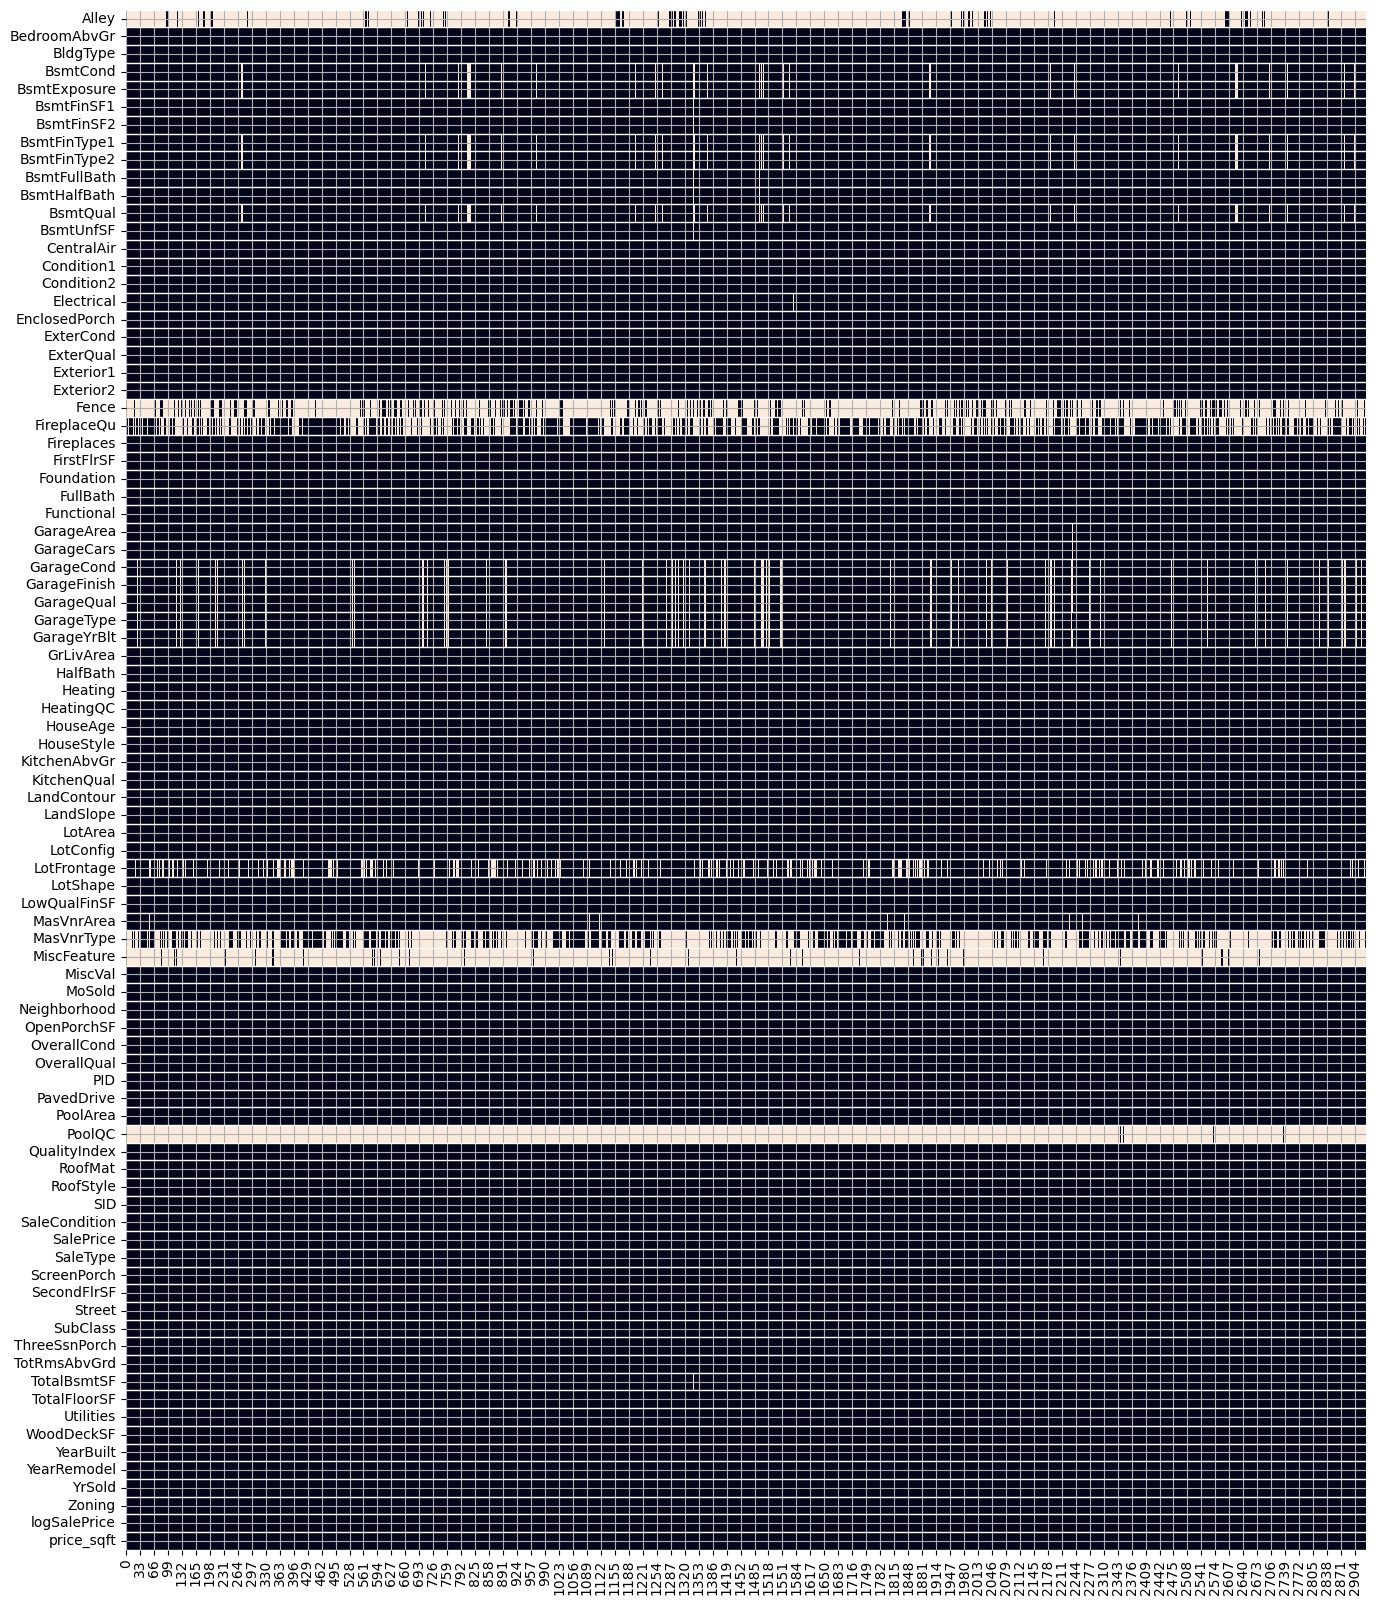

In [44]:
fig, ax = plt.subplots(figsize=(16, 20))
plt.rcParams["axes.grid"] = True

df_heat=df.sort_index(axis=1, ascending=False)
sns.heatmap(df_heat.T.isnull(), ax=ax, cbar=False).invert_yaxis()
ax.hlines(range(len(df_heat)), *ax.get_xlim(), color='white', linewidths=1)
ax.vlines([], [], [])
plt.yticks(rotation = 360)
plt.show()

In [45]:
Nulls=[]
for i in df.columns:
    if df[i].isnull().sum() > 0:
        Nulls.append(i)
        print("Column: {} Null Count: {}".format((i+"                      ")[0:18], df[i].isnull().sum()))
        

Column: LotFrontage        Null Count: 490
Column: Alley              Null Count: 2732
Column: MasVnrType         Null Count: 1775
Column: MasVnrArea         Null Count: 23
Column: BsmtQual           Null Count: 80
Column: BsmtCond           Null Count: 80
Column: BsmtExposure       Null Count: 83
Column: BsmtFinType1       Null Count: 80
Column: BsmtFinSF1         Null Count: 1
Column: BsmtFinType2       Null Count: 81
Column: BsmtFinSF2         Null Count: 1
Column: BsmtUnfSF          Null Count: 1
Column: TotalBsmtSF        Null Count: 1
Column: Electrical         Null Count: 1
Column: BsmtFullBath       Null Count: 2
Column: BsmtHalfBath       Null Count: 2
Column: FireplaceQu        Null Count: 1422
Column: GarageType         Null Count: 157
Column: GarageYrBlt        Null Count: 159
Column: GarageFinish       Null Count: 159
Column: GarageCars         Null Count: 1
Column: GarageArea         Null Count: 1
Column: GarageQual         Null Count: 159
Column: GarageCond         Null 

# Null Value Cleanup

In [46]:
# Convert 'None' strings to actual NaN

df.replace('None', pd.NaT)

,SID,PID,SubClass,Zoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalFloorSF,HouseAge,QualityIndex,logSalePrice,price_sqft
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,5,2010,WD,Normal,215000,1656,50,30,12.278393,129.830918
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,6,2010,WD,Normal,105000,896,49,30,11.561716,117.187500
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,6,2010,WD,Normal,172000,1329,52,36,12.055250,129.420617
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,4,2010,WD,Normal,244000,2110,42,35,12.404924,115.639810
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,3,2010,WD,Normal,189900,1629,13,25,12.154253,116.574586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,...,3,2006,WD,Normal,142500,1003,22,36,11.867097,142.073779
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,...,6,2006,WD,Normal,131000,902,23,25,11.782953,145.232816
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,7,2006,WD,Normal,132000,970,14,25,11.790557,136.082474
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,4,2006,WD,Normal,170000,1389,32,25,12.043554,122.390209


### LotFrontage 


In [47]:
df['LotFrontage']=df['LotFrontage'].fillna(df['LotFrontage'].median())

### Alley


In [48]:
df['Alley']=df['Alley'].fillna('No alley')

### MasVnrType & MasVnrArea: Filling with None and 0

In [49]:
df['MasVnrType']=df['MasVnrType'].fillna('None')
df['MasVnrArea']=df['MasVnrArea'].fillna(0)

### BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2

In [50]:
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    df[col].fillna('No basement')

### Categorical garage-related columns (fill with 'No garage' or 0 because NaN likely means no garage). We can also do this for the integer year built and fill in 0 as the categorical.

In [51]:
for col in ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']:
    if df[col].dtype == 'object':
        df[col]=df[col].fillna('No garage')
    else:
        df[col]=df[col].fillna('None')

### Numeric garage-related columns: Fill with zero Assuming there is no garage.

In [65]:
   
df['GarageCars']=df['GarageCars'].fillna(0)
df['GarageArea']=df['GarageArea'].fillna(0)

SyntaxError: invalid syntax (1889991687.py, line 1)

#### PoolQC: fill with 'No pool' because NaN likely means no pool

In [52]:
df['PoolQC']=df['PoolQC'].fillna('No pool')


### Fence: fill with 'No fence' because NaN likely means no fence

In [53]:
df['Fence']=df['Fence'].fillna('No fence')

### MiscFeature: fill with 'No feature' because NaN likely means there are no additional features


In [54]:
df['MiscFeature']=df['MiscFeature'].fillna('No feature')

### Electrical: As this is a categorical feature, we can replace missing values with the most common class

In [55]:
df['Electrical']=df['Electrical'].fillna(df['Electrical'].mode()[0])

### FireplaceQu: NaN probably means no fireplace

In [56]:
df['FireplaceQu']=df['FireplaceQu'].fillna('No fireplace')

### BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, and BsmtFinType2: Fill missing categorical basement columns with 'No basement'

In [57]:
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    df[col]=df[col].fillna('No basement')

### BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, & BsmtHalfBath: Fill missing numerical basement columns with 0

In [58]:
for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
    df[col]=df[col].fillna(0)

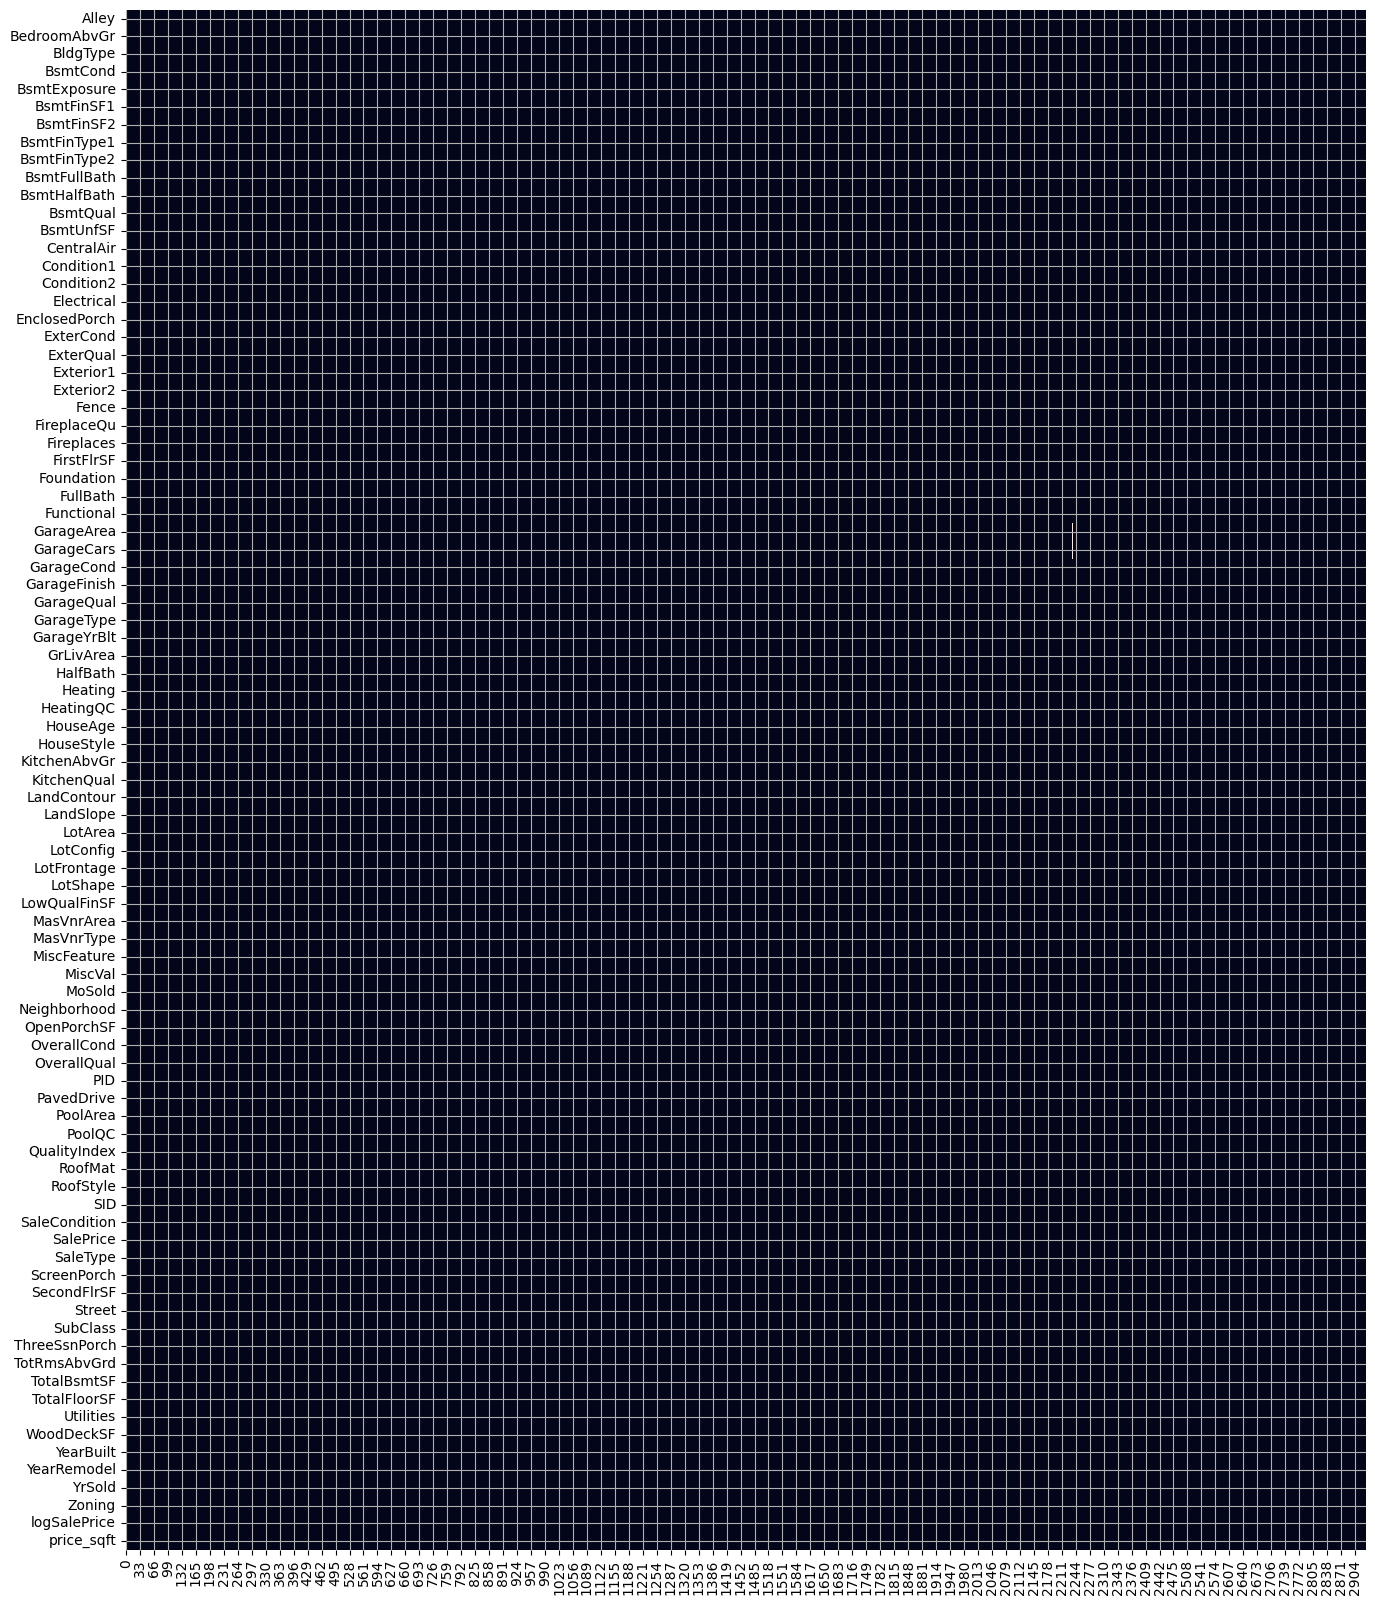

In [59]:
fig, ax = plt.subplots(figsize=(16, 20))
plt.rcParams["axes.grid"] = True

df_heat1=df.sort_index(axis=1, ascending=False)
sns.heatmap(df_heat1.T.isnull(), ax=ax, cbar=False).invert_yaxis()
plt.yticks(rotation = 360)
plt.show()

### Other columns: fill with appropriate values or drop, depending on the context and the amount of missing data

In [ ]:
plt.hist(df['price_sqft'])
plt.title('Price per square foot')
plt.show()

In [ ]:
subdat = df[["TotalFloorSF", "HouseAge", "QualityIndex", "price_sqft", 
                 "SalePrice", "LotArea", "BsmtFinSF1", "Neighborhood", 
                 "HouseStyle", "LotShape", "OverallQual", "logSalePrice", 
                 "TotalBsmtSF", "HouseStyle"]]
subdatnum = df[["TotalFloorSF", "HouseAge", "QualityIndex", 
                    "SalePrice", "LotArea", "OverallQual", "logSalePrice"]]
print(subdat.info())


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
f, axes = plt.subplots(3, 3, figsize=(20, 15))

# Univariate EDA
sns.countplot(data=subdat, x='LotShape', ax=axes[0, 0]).set_title('Number of houses per Lotshape')

sns.histplot(data=subdat, x='SalePrice', binwidth=10000, ax=axes[0, 1]).set_title('Distribution of Sale Price')

sns.histplot(data=subdat, x='TotalFloorSF', binwidth=100, ax=axes[0, 2]).set_title('Distribution of TotalFloorSF')

sns.histplot(data=subdat, x='QualityIndex', binwidth=10, ax=axes[1, 0]).set_title('Distribution of QualityIndex')

# Bivariate EDA
sns.scatterplot(data=subdat, x='TotalFloorSF', y='QualityIndex', ax=axes[1, 1]).set_title('Scatter Plot of Total Floor SF vs QualityIndex')

sns.scatterplot(data=subdat, x='TotalFloorSF', y='HouseAge', ax=axes[1, 2]).set_title('Scatter Plot of Total Floor SF vs HouseAge')

sns.boxplot(data=subdat, x='LotShape', y='HouseAge', ax=axes[2, 0]).set_title('Distribution of HouseAge')

# Model focussed EDA
sns.scatterplot(data=subdat, x='TotalFloorSF', y='SalePrice', ax=axes[2, 1]).set_title('Scatter Plot of Sale Price vs Total Floor SF')
sns.regplot(data=subdat, x='TotalFloorSF', y='SalePrice', scatter=False, color='red', ax=axes[2, 1])

sns.boxplot(data=subdat, x='LotShape', y='SalePrice', ax=axes[2, 2]).set_title('Distribution of Sale Price')

plt.tight_layout()
plt.show()

# Correlation plot
corr = subdatnum.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
subdat_numeric = subdat.select_dtypes(include=np.number)
sns.pairplot(subdat_numeric)
plt.show()

In [ ]:
This is an 